In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from astropy.visualization.hist import hist as fancyhist
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
%load_ext tensorboard
from tensorboard.plugins.hparams import api as hp

In [3]:
df_quasar = pd.read_csv("../../solutions/galaxyquasar.csv")
df_quasar

,u,g,r,i,z,class,z1,zerr
0,18.97213,18.53676,18.58280,18.34936,18.29215,QSO,0.522819,0.000155
1,19.24592,17.47646,16.47817,16.04472,15.68851,GALAXY,0.122846,0.000028
2,19.43536,17.70268,16.91565,16.58327,16.39128,GALAXY,0.000000,0.000000
3,19.31626,18.18312,17.39591,16.94549,16.65395,GALAXY,0.147435,0.000009
4,19.28828,19.11188,18.88937,18.80013,18.49183,QSO,2.011455,0.000631
...,...,...,...,...,...,...,...,...
49995,19.37295,18.12382,17.39886,16.98503,16.70585,GALAXY,0.113016,0.000011
49996,18.52021,16.88262,16.03280,15.56884,15.22454,GALAXY,0.085063,0.000014
49997,18.62718,17.30876,16.87371,16.62399,16.42296,GALAXY,0.054429,0.000008
49998,19.55140,18.27711,17.62101,17.21947,17.03347,GALAXY,0.112571,0.000009


In [4]:
name = df_quasar['class'].copy()

In [6]:
le = LabelEncoder()
df_quasar['class'] = le.fit_transform(df_quasar['class'])
labels = le.inverse_transform(df_quasar['class'])
class_names = le.classes_
print(class_names)

[0 1]


In [7]:
u_g = np.array(df_quasar['u'] - df_quasar['g'])
g_r = np.array(df_quasar['g'] - df_quasar['r'])
r_i = np.array(df_quasar['r'] - df_quasar['i'])
i_z = np.array(df_quasar['i'] - df_quasar['z'])
class_labels = np.array(df_quasar['class'])

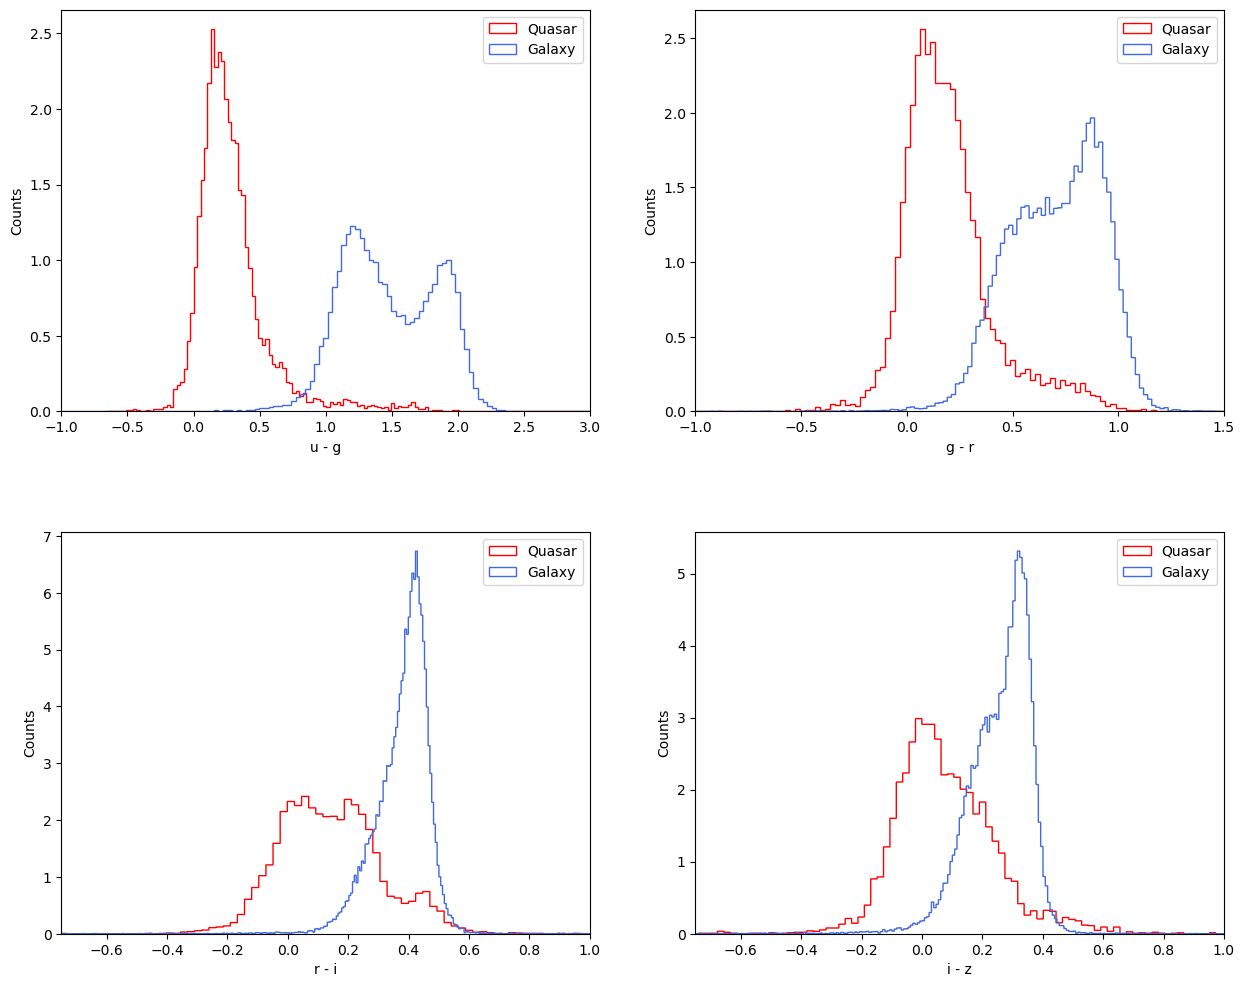

In [8]:
fig, axs = plt.subplots(2, 2, figsize=(15, 12))

fancyhist(u_g[df_quasar['class']==1], bins="freedman", ax=axs[0,0], density=True, ec='red', histtype='step', label = 'Quasar')
fancyhist(u_g[df_quasar['class']==0], bins="freedman", ax=axs[0,0], density=True, ec='royalblue', histtype='step', label = 'Galaxy')
axs[0,0].set_xlabel('u - g')
axs[0,0].set_ylabel('Counts')
axs[0,0].set_xlim(-1, 3)
axs[0,0].legend()

fancyhist(g_r[df_quasar['class']==1], bins="freedman", ax=axs[0,1], density=True, ec='red', histtype='step', label = 'Quasar')
fancyhist(g_r[df_quasar['class']==0], bins="freedman", ax=axs[0,1], density=True, ec='royalblue', histtype='step', label = 'Galaxy')
axs[0,1].set_xlabel('g - r')
axs[0,1].set_ylabel('Counts')
axs[0,1].set_xlim(-1, 1.5)
axs[0,1].legend()

fancyhist(r_i[df_quasar['class']==1], bins="freedman", ax=axs[1,0], density=True, ec='red', histtype='step', label = 'Quasar')
fancyhist(r_i[df_quasar['class']==0], bins="freedman", ax=axs[1,0], density=True, ec='royalblue', histtype='step', label = 'Galaxy')
axs[1,0].set_xlabel('r - i')
axs[1,0].set_ylabel('Counts')
axs[1,0].set_xlim(-0.75, 1)
axs[1,0].legend()

fancyhist(i_z[df_quasar['class']==1], bins="freedman", ax=axs[1,1], density=True, ec='red', histtype='step', label = 'Quasar')
fancyhist(i_z[df_quasar['class']==0], bins="freedman", ax=axs[1,1], density=True, ec='royalblue', histtype='step', label = 'Galaxy')
axs[1,1].set_xlabel('i - z')
axs[1,1].set_ylabel('Counts')
axs[1,1].set_xlim(-0.75, 1)
axs[1,1].legend()

plt.subplots_adjust(hspace=0.3)
plt.show()

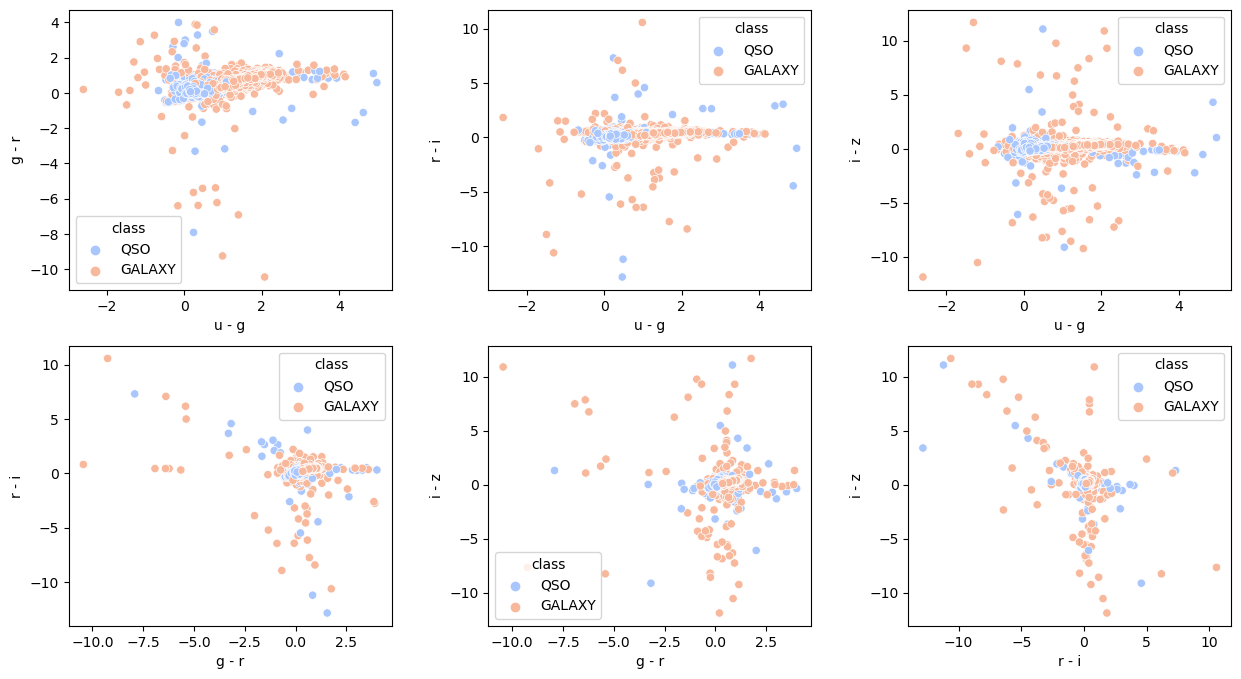

In [9]:
color = pd.DataFrame({'u - g': u_g, 'g - r': g_r, 'r - i': r_i, 'i - z': i_z})

fig, axs = plt.subplots(2, 3, figsize=(15, 8))

sns.scatterplot(data=color, x='u - g', y='g - r', hue=name, ax = axs[0,0], palette='coolwarm')
sns.scatterplot(data=color, x='u - g', y='r - i', hue=name, ax = axs[0,1], palette='coolwarm')
sns.scatterplot(data=color, x='u - g', y='i - z', hue=name, ax = axs[0,2], palette='coolwarm')
sns.scatterplot(data=color, x='g - r', y='r - i', hue=name, ax = axs[1,0], palette='coolwarm')
sns.scatterplot(data=color, x='g - r', y='i - z', hue=name, ax = axs[1,1], palette='coolwarm')
sns.scatterplot(data=color, x='r - i', y='i - z', hue=name, ax = axs[1,2], palette='coolwarm')

plt.subplots_adjust(wspace=0.3)
plt.show()

In [10]:
scaler = StandardScaler().set_output(transform="pandas")
data_scaled = scaler.fit_transform(color)
X_train, X_test, y_train, y_test = train_test_split(data_scaled.to_numpy(), class_labels, test_size=0.3, random_state=42)

## Simpliest model

In [11]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=(4,)),
    tf.keras.layers.Dense(units=5, activation='relu'),
    tf.keras.layers.Dense(units=1)
    ])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 5)              │            25 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31 (124.00 B)

 Trainable params: 31 (124.00 B)

 Non-trainable params: 0 (0.00 B)

In [12]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])
model.fit(X_train, y_train, validation_split=0.3, epochs=10)

Epoch 1/10
766/766 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9329 - loss: 0.5188 - val_accuracy: 0.9702 - val_loss: 0.2103
Epoch 2/10
766/766 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9717 - loss: 0.1996 - val_accuracy: 0.9788 - val_loss: 0.1688
Epoch 3/10
766/766 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9791 - loss: 0.1672 - val_accuracy: 0.9820 - val_loss: 0.1465
Epoch 4/10
766/766 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9790 - loss: 0.1798 - val_accuracy: 0.9822 - val_loss: 0.1472
Epoch 5/10
766/766 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9840 - loss: 0.1393 - val_accuracy: 0.9839 - val_loss: 0.1466
Epoch 6/10
766/766 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9837 - loss: 0.1472 - val_accuracy: 0.9844 - val_loss: 0.1441
Epoch 7/10
766/766 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9831 - loss: 0.1496 - val_accuracy: 0.9843 - val_loss: 0.1360
Epoch 8/10
766/766 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9825 - loss: 0.1570 - val_accuracy: 0.

In [13]:
model.evaluate(X_test, y_test)

469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9829 - loss: 0.1618


[0.14582541584968567, 0.9841333627700806]

In [14]:
y_prob = model.predict(X_test)

469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


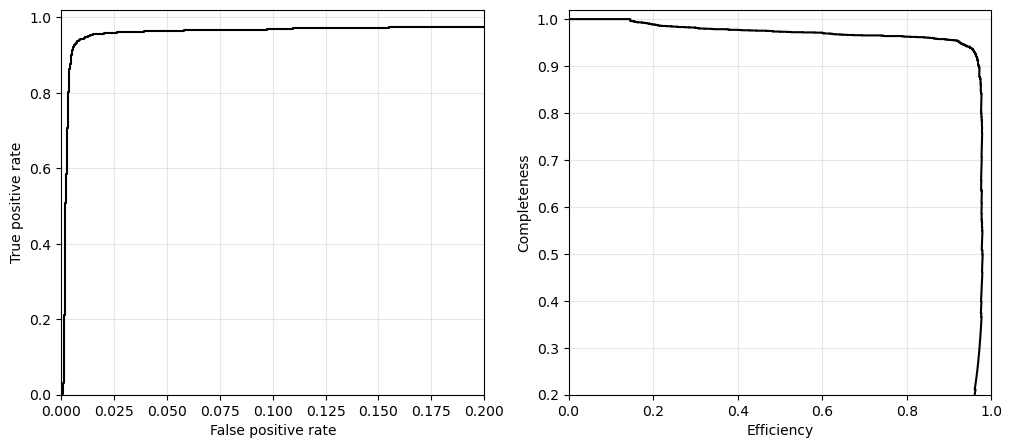

In [15]:
fpr, tpr, thresh = roc_curve(y_test, y_prob)
precision, recall, thresh2 = precision_recall_curve(y_test, y_prob)
fpr = np.concatenate([[0], fpr])
tpr = np.concatenate([[0], tpr])
# Here we add (1,0) 
precision = np.concatenate([[0], precision])
recall = np.concatenate([[1], recall])
thresh2 = np.concatenate([[0], thresh2])

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].plot(fpr, tpr, color = 'black')
axs[0].set_xlabel('False positive rate')
axs[0].set_ylabel('True positive rate')
axs[0].set_xlim(0, 0.2)
axs[0].set_ylim(0, 1.02)
axs[0].grid(alpha=0.3)

axs[1].plot(precision, recall, color = 'black')
axs[1].set_xlabel('Efficiency')
axs[1].set_ylabel('Completeness')
axs[1].set_xlim(0, 1.0)
axs[1].set_ylim(0.2, 1.02)
axs[1].grid(alpha=0.3)

plt.show()

In [16]:
print('Confusion matrix:\n', confusion_matrix(y_test, y_prob>0.5))

Confusion matrix:
 [[12712   100]
 [  138  2050]]


## Tensorboard

In [17]:
HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([5, 10, 15, 20]))
HP_DROPOUT = hp.HParam('dropout', hp.Discrete([0.0, 0.1, 0.2, 0.3, 0.4, 0.5]))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd', 'adagrad']))

METRIC_ACCURACY = 'accuracy'

with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
  hp.hparams_config(
    hparams=[HP_NUM_UNITS, HP_DROPOUT, HP_OPTIMIZER],
    metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
  )

In [18]:
def train_test_model(hparams):
  model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(4,)),
    tf.keras.layers.Dense(hparams[HP_NUM_UNITS], activation='relu'),
    tf.keras.layers.Dropout(hparams[HP_DROPOUT]),
    tf.keras.layers.Dense(1, activation='sigmoid'),
  ])
  model.compile(
      optimizer=hparams[HP_OPTIMIZER],
      loss=tf.keras.losses.BinaryCrossentropy(),
      metrics=['accuracy'],
  )

  model.fit(X_train, y_train, epochs=1) # Run with 1 epoch to speed things up for demo purposes
  _, accuracy = model.evaluate(X_test, y_test)
  return accuracy

In [19]:
def run(run_dir, hparams):
  with tf.summary.create_file_writer(run_dir).as_default():
    hp.hparams(hparams)  # record the values used in this trial
    accuracy = train_test_model(hparams)
    tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)

In [20]:
session_num = 0

for num_units in HP_NUM_UNITS.domain.values:
  for dropout_rate in HP_DROPOUT.domain.values:
    for optimizer in HP_OPTIMIZER.domain.values:
      hparams = {
          HP_NUM_UNITS: num_units,
          HP_DROPOUT: dropout_rate,
          HP_OPTIMIZER: optimizer,
      }
      run_name = "run-%d" % session_num
      print('--- Starting trial: %s' % run_name)
      print({h.name: hparams[h] for h in hparams})
      run('logs/hparam_tuning/' + run_name, hparams)
      session_num += 1

--- Starting trial: run-0
{'num_units': 5, 'dropout': 0.0, 'optimizer': 'adagrad'}
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.2043 - loss: 0.7940
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4858 - loss: 0.7162
--- Starting trial: run-1
{'num_units': 5, 'dropout': 0.0, 'optimizer': 'adam'}
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.7033 - loss: 0.6001
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9814 - loss: 0.1243
--- Starting trial: run-2
{'num_units': 5, 'dropout': 0.0, 'optimizer': 'sgd'}
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9663 - loss: 0.3436
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9819 - loss: 0.1351
--- Starting trial: run-3
{'num_units': 5, 'dropout': 0.1, 'optimizer': 'adagrad'}
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.6884 - loss: 0.6114
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7475 - loss: 0.5359
--- Starting trial: run-4
{'num_units': 5, 'dropout': 0.1, 'optimiz

In [42]:
%tensorboard --logdir logs/hparam_tuning --port 6007

In [31]:
#From tensorflow
best_units = 20
best_dropout = 0.2
best_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

## Optimized model

In [32]:
opt_model = tf.keras.Sequential([
    tf.keras.Input(shape=(4,)),
    tf.keras.layers.Dense(units=best_units, activation='relu'),
    tf.keras.layers.Dropout(best_dropout),
    tf.keras.layers.Dense(1, activation='sigmoid'),
    ])
opt_model.summary()

Model: "sequential_74"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_148 (Dense)               │ (None, 20)             │           100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_72 (Dropout)            │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_149 (Dense)               │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121 (484.00 B)

 Trainable params: 121 (484.00 B)

 Non-trainable params: 0 (0.00 B)

In [33]:
opt_model.compile(loss = tf.keras.losses.BinaryCrossentropy(), optimizer = best_optimizer, metrics=['accuracy'])
opt_model.fit(X_train, y_train, validation_split=0.3, epochs=20)

Epoch 1/20
766/766 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9187 - loss: 0.3485 - val_accuracy: 0.9820 - val_loss: 0.0963
Epoch 2/20
766/766 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9786 - loss: 0.0988 - val_accuracy: 0.9834 - val_loss: 0.0733
Epoch 3/20
766/766 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9809 - loss: 0.0828 - val_accuracy: 0.9829 - val_loss: 0.0719
Epoch 4/20
766/766 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9795 - loss: 0.0852 - val_accuracy: 0.9830 - val_loss: 0.0696
Epoch 5/20
766/766 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9832 - loss: 0.0731 - val_accuracy: 0.9835 - val_loss: 0.0686
Epoch 6/20
766/766 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9813 - loss: 0.0761 - val_accuracy: 0.9834 - val_loss: 0.0681
Epoch 7/20
766/766 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9806 - loss: 0.0784 - val_accuracy: 0.9836 - val_loss: 0.0667
Epoch 8/20
766/766 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9796 - loss: 0.0815 - val_accuracy: 0.

In [34]:
opt_model.evaluate(X_test, y_test)

469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9828 - loss: 0.0739


[0.0715901330113411, 0.9837999939918518]

In [35]:
y_prob_opt = opt_model.predict(X_test)

469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


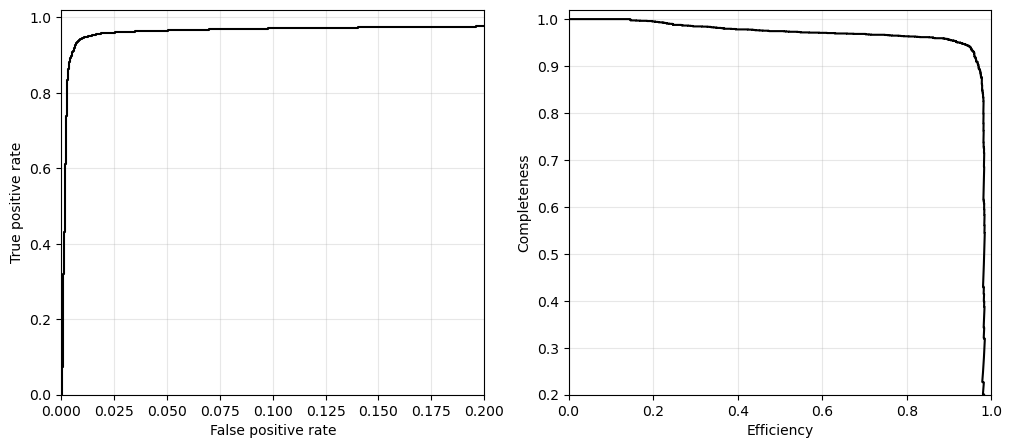

In [36]:
fpr_opt, tpr_opt, thresh_opt = roc_curve(y_test, y_prob_opt)
precision_opt, recall_opt, thresh2_opt = precision_recall_curve(y_test, y_prob_opt)
fpr_opt = np.concatenate([[0], fpr_opt])
tpr_opt = np.concatenate([[0], tpr_opt])
# Here we add (1,0) 
precision_opt = np.concatenate([[0], precision_opt])
recall_opt = np.concatenate([[1], recall_opt])
thresh2_opt = np.concatenate([[0], thresh2_opt])

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].plot(fpr_opt, tpr_opt, color = 'black')
axs[0].set_xlabel('False positive rate')
axs[0].set_ylabel('True positive rate')
axs[0].set_xlim(0, 0.2)
axs[0].set_ylim(0, 1.02)
axs[0].grid(alpha=0.3)

axs[1].plot(precision_opt, recall_opt, color = 'black')
axs[1].set_xlabel('Efficiency')
axs[1].set_ylabel('Completeness')
axs[1].set_xlim(0, 1.0)
axs[1].set_ylim(0.2, 1.02)
axs[1].grid(alpha=0.3)

plt.show()

In [37]:
print('Confusion matrix:\n', confusion_matrix(y_test, y_prob_opt>0.5))

Confusion matrix:
 [[12717    95]
 [  148  2040]]
